In [357]:
import torch
from torch.func import functional_call, vmap, vjp, jvp, jacrev
from pykeops.torch import LazyTensor
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from functools import partial
from itertools import product
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

In [175]:
plt.rcParams['text.usetex'] = True

In [714]:
image_dir = './images'

## Single Index Model

In [689]:
D = 30 # ambient dimension of the problem
n = 200 # number of samples per environment
sigma = 0.5 # variance 
k = 2
T = 20 # number of environments

In [690]:
def generate_data(n_sample, regression_fcn, weights, B):

    D, k = B.shape[0], B.shape[1]

    # Non isotropic features per environment
    X = torch.randn(n_sample, D, requires_grad = False) / np.sqrt(D)
    X *= weights
    Z = X @ B # [n, k]

    y = (
        regression_fcn(Z)
        + sigma * torch.randn(n_sample)
    ).unsqueeze(1)

    return X, y, Z

def generate_data_from_multiple_envs(
    D = 100, # ambient dimension of the problem
    n = 50, # number of samples per environment
    sigma = 1e-3, # variance 
    k = 2, # number of indices
    T = 20 # number of environments
):

    # Index directions
    B = torch.randn( D, k, requires_grad = False ) / np.sqrt(D) 

    nonlinearities = []
    data_train = []
    data_test = []
    
    for env in range(T):
    
        # create a polynomial
        coef = np.random.standard_cauchy(size = 3)
        # freeze the function coeficients
        func = partial(lambda z, coef: coef[0] * (z[1] * 3)** 2 + coef[1] * z[1] * z[0] - coef[1] * (z[0] * 4)**3, coef = list(coef.copy()))
        nonlinearity = vmap(func, in_dims = 0)
        
        weights = torch.rand(1,D)
        X, y, Z = generate_data(int(0.8 * n), regression_fcn = nonlinearity, weights=weights, B=B)
        X_test, y_test, Z_test = generate_data(int(0.2 * n), regression_fcn = nonlinearity, weights=weights, B=B)
    
        nonlinearities.append(nonlinearity)
        data_train.append([X, y, Z])
        data_test.append([X_test, y_test, Z_test])

    return B, data_train, data_test, nonlinearities

In [691]:
# Contaminate the data
n_contamination = 0

B, data_train, data_test, nonlinearities = generate_data_from_multiple_envs(D, n, sigma, k ,T - n_contamination)

if n_contamination > 0:
    contaminated = generate_data_from_multiple_envs(D, n, sigma, k , n_contamination) # data generated from a different subspace B_contaminated
    data_train.extend(contaminated[1])
    data_test.extend(contaminated[2])
    nonlinearities.extend(contaminated[3])

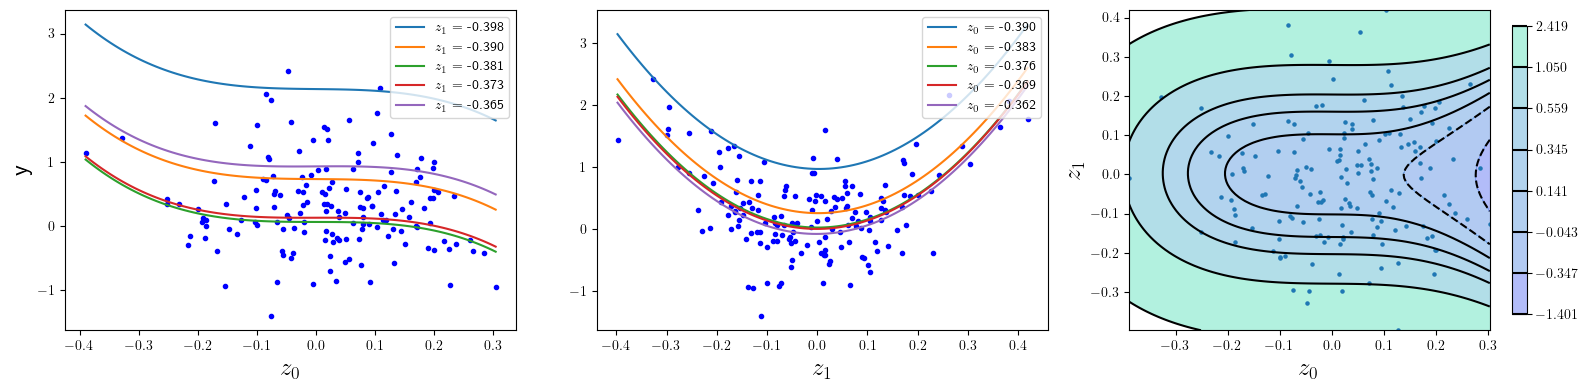

In [811]:
# Plotting the contours of nonlinear map for different values of Z
grid_res = 100
env = 1
X, y, Z = data_train[env]
nonlinearity = nonlinearities[env]
fig, axes = plt.subplots(ncols = k+1, figsize = (16,4), tight_layout = True)
cmap = plt.colormaps["winter"].with_extremes(under="magenta", over="yellow")

Z_ = list(map(lambda z: torch.linspace(z.min(), z.max(), grid_res) , Z.T ))
Z_mesh = torch.meshgrid(*Z_)
Z_mesh_unraveled = torch.stack(list(map(lambda z: z.ravel(), Z_mesh)), axis = -1)
heatmat = nonlinearity(Z_mesh_unraveled).reshape([grid_res] * k)

to_numpy = lambda tensor: tensor.cpu().numpy()
assert k == 2 # only works in 2 dimensions
quantile_levels = np.quantile(to_numpy(y).squeeze(1), q = np.linspace(0,1,8))
cs = axes[-1].contourf(*map(to_numpy, list(Z_mesh) + [heatmat]), levels = quantile_levels, cmap = cmap, alpha = 0.3)
CS = axes[-1].contour(*map(to_numpy, list(Z_mesh) + [heatmat]), levels = quantile_levels, colors = 'k')
# contour colorbar
cbar = fig.colorbar(cs, ax = axes[-1], shrink = 0.9)
cbar.add_lines(CS)
axes[-1].scatter(*map(to_numpy, Z.T), s = 5)
axes[-1].set_xlabel(r'$z_0$', fontsize = 18);
axes[-1].set_ylabel(r'$z_1$', fontsize = 18);

# plot data points

for i, ax in enumerate(axes[:k].ravel()):
    ax.plot( Z.detach().numpy()[:,i], y.detach().numpy(), 'b.' )
    ax.set_xlabel(fr'$z_{i}$', fontsize = 18)
    # plot contours
    for row_idx, row in enumerate(to_numpy(heatmat).swapaxes(1,i)[::20,...]):
        z1 = to_numpy(Z_[1-i])[row_idx]
        ax.plot(to_numpy(Z_[i]) , row, label = fr'$z_{1-i}$ = {z1:.3f}' )
    ax.legend(loc = 'upper right')

axes[0].set_ylabel('y', fontsize = 18);

In [812]:
fig.savefig(image_dir + '/regression_fcn.png')

In [693]:
def gaussian_kernel(x, y, sigma = 10.0):
    x_i = LazyTensor(x[:, None, :])  # (M, 1, D)
    y_j = LazyTensor(y[None, :, :])  # (1, N, D)
    D_ij = ((x_i - y_j) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
    return ((-D_ij / (2 * sigma**2)).exp())  # (M, N) symbolic Gaussian kernel matrix

In [694]:
def kernel_predict(X_train, a, sigma = 10.0):
    
    def kernel_predict_(x):
        if len(x.shape) == 1:
            x_ = x.unsqueeze(0)
        else:
            x_ = x
        y_hat = (gaussian_kernel(x_, X_train, sigma = sigma) @ a).squeeze(1)
        return y_hat
    return kernel_predict_

def fit(X_train, y_train, kernel = gaussian_kernel, **params):
    alpha = float(params.pop('alpha', 0.1))
    sigma = float(params.pop('sigma', 10))
    
    K_xx = kernel(X_train, X_train, sigma = sigma)
    a = K_xx.solve(y_train, alpha = alpha)
    predictor = kernel_predict(X_train, a, sigma = sigma)

    return predictor

def kernel_grad(predictor):
    pred_grad = vmap(jacrev(predictor))
    
    def kernel_grad_(x_evaluate):
        kernel_grad_evaluated = pred_grad(x_evaluate)
        return kernel_grad_evaluated

    return kernel_grad_

In [695]:
def hyper_param_search(X_test, y_test, X_train, y_train, **params):
    param_names = list(params.keys())
    hyperparams = np.vstack([elem.ravel() for elem in np.meshgrid( *params.values() )]).T
    errors = np.empty([hyperparams.shape[0] , 2])

    for i, row in enumerate(hyperparams):
        param = { key: val for key, val in zip(param_names, row) }
        predictor = fit(X_train, y_train, kernel = gaussian_kernel, **param)

        l2_test_error = ( (y_test.squeeze(1) - predictor(X_test)) ** 2 )
        errors[i,:] = l2_test_error.mean(0).detach().numpy(), l2_test_error.std(0).detach().numpy()

    # Refit on the entire data
    optimal_idx = np.argmin(errors[:,0] + 0.5 * errors[:,1])
    param_optimal = { key: val for key, val in zip(param_names, hyperparams[optimal_idx, :]) }
    X_tot, y_tot = torch.vstack((X_train, X_test)), torch.vstack((y_train, y_test))
    predictor_optimal = fit( X_tot, y_tot , kernel = gaussian_kernel, **param_optimal)
    final_training_error = (( y_tot.squeeze(1) - predictor(X_tot)) ** 2 ).mean(0).detach().numpy()

    return predictor_optimal, param_optimal, float(final_training_error)

def run(data_train, data_test, alphas = np.logspace(-6,1, 10), sigmas = np.logspace(-1,1, 5), print_log = False):
    # Find predictors for each environment
    predictors = []
    optimal_parameters = []
    errors = []
    T = len(data_train)
    
    for env in range(T):
        if print_log:
            print(f'Training for environment = {env}')
        X, y, Z = data_train[env]
        X_test, y_test, Z_test = data_test[env]
        predictor, optimal_params, error = hyper_param_search(X_test, y_test, 
                                                       X, y, 
                                                       alpha = alphas, 
                                                       sigma = sigmas
                                                      )
        predictors.append(predictor)
        optimal_parameters.append(optimal_params)
        errors.append(error)

    return predictors, optimal_parameters, errors

In [696]:
predictors, optimal_parameters, errors = run(data_train, data_test, print_log=True)

Training for environment = 0
Training for environment = 1
Training for environment = 2
Training for environment = 3
Training for environment = 4
Training for environment = 5
Training for environment = 6
Training for environment = 7
Training for environment = 8
Training for environment = 9
Training for environment = 10
Training for environment = 11
Training for environment = 12
Training for environment = 13
Training for environment = 14
Training for environment = 15
Training for environment = 16
Training for environment = 17
Training for environment = 18
Training for environment = 19


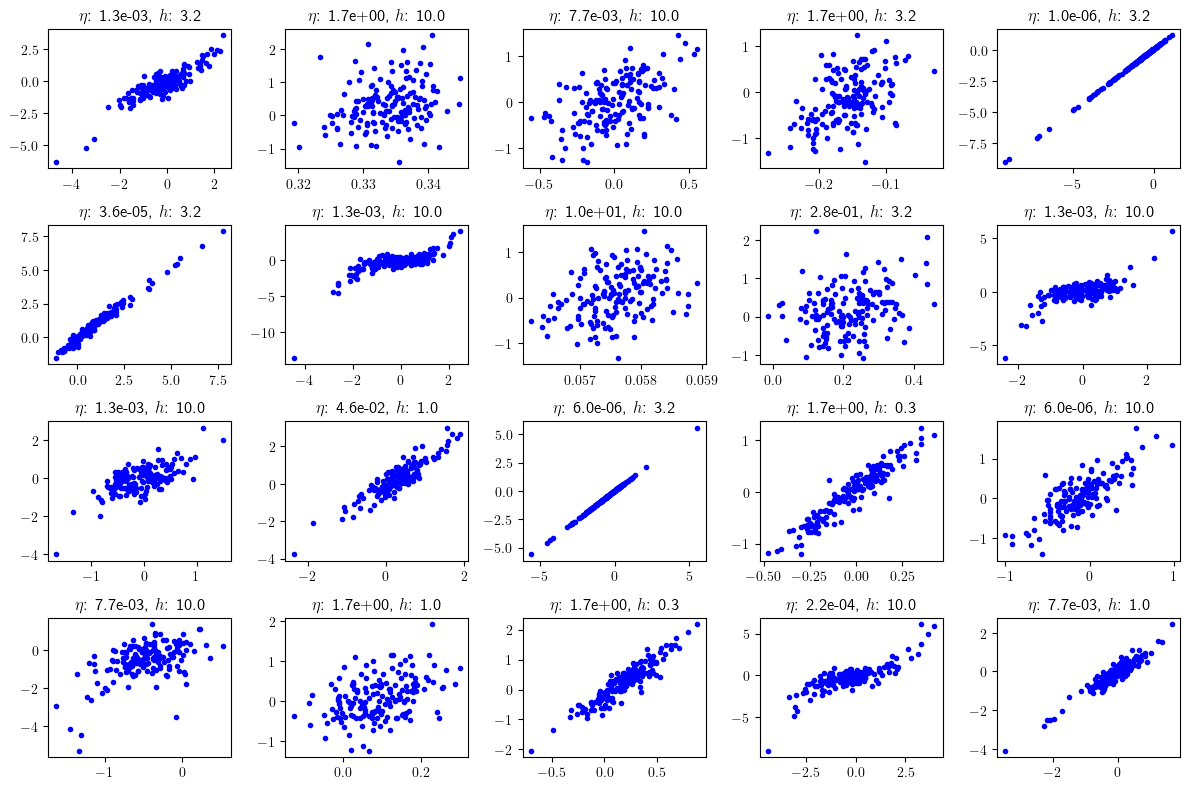

In [697]:
# diagnosis plot for each environment
fig, axes = plt.subplots(4,5, figsize = (12,8), tight_layout = True)

for env, ax in enumerate(axes.ravel()):
    X, y, Z = data_train[env]
    ax.plot(predictors[env](X).detach().numpy(), y.detach().numpy(), 'b.', label = f'Env = {env}')
    #ax.legend(loc = 'lower right')
    ax.set_title(r'$\eta$: {alpha:,.1e}, $h$: {sigma:,.1f}'.format(**optimal_parameters[env]))

In [698]:
def compute_matrix(predictors, data_train, data_test):
    T = len(data_train)
    # compute each environments gradient function
    pred_grads = list(map(kernel_grad, predictors))
    
    matrix = [ [] for _ in range(T) ]
    
    for row_env in range(T):
        pred_grad = pred_grads[row_env]
        for col_env in range(T):
            X, y, Z = data_train[col_env]
            X_test, y_test, Z_test = data_test[col_env]
            X_tot, y_tot = torch.vstack((X, X_test)), torch.vstack((y, y_test))
    
            # gradient outerproduct averaged over observed data
            pred_grad_eval = pred_grad(X_tot)
            grad_outerprod = (pred_grad_eval * pred_grad_eval.transpose(1,2)).mean(0)
            matrix[row_env].append( grad_outerprod )
    
    concat = lambda mat: torch.vstack(list(map( torch.hstack, mat)))
    
    # concatenate
    M = concat(matrix)

    return M, matrix

In [699]:
M, matrix = compute_matrix(predictors, data_train, data_test)

In [700]:
def grassmanian_dist( B1, B2 ):

    assert B1.shape[1] == B2.shape[1]
    # compute the grassmanian distance between column space of B1 and B2
    U1, _, _ = np.linalg.svd(B1, full_matrices=False)
    U2, _, _ = np.linalg.svd(B2, full_matrices=False)

    cosine_angles = np.linalg.svd( U1.T @ U2, compute_uv = False )
    return cosine_angles

def mean_aggregation(subspace, normalization = False):
    # assuming that subspace has dimension [r, D, T] where is the rank of the subspace
    if normalization:
        subspace /= np.sqrt((subspace ** 2).sum(axis = 1, keepdims = True)) # normalize over [:, D, :]

    # aggregation step
    subspace_est = np.mean(subspace, axis = -1).T # [D, r]

    return subspace_est

def compute_dist( egop, B, colspace = False, aggregation_method = mean_aggregation):
    D, k = B.shape
    T = egop.shape[0] // D

    if torch.is_tensor(egop):
        egop = egop.detach().numpy()
    
    # pick the first r directions
    r = k
    U, S, Vh = np.linalg.svd(egop, full_matrices = False)

    if colspace:
        # important directions in column space of `egop`. Each column corresponds to a single dataset applied to various models.
        U_est = U[:,:r].T
    else:
        # important directions in row space of `egop`. Each row corresponds to different dataset applied to the same predictor
        U_est = Vh[:r,:]

    U_est = U_est.reshape((r, T, D), order = 'C').swapaxes(1,2) #important reshaping [r, D, T]

    # aggregation step
    subspace_est = aggregation_method(U_est.copy())

    # compute the distance between estimated subspace and true centaral subspace
    cosine_angles = grassmanian_dist(subspace_est, B)

    return cosine_angles
    

In [701]:
# Per environment distance
dist = lambda egop: compute_dist(egop, B, colspace = False)
cosine_angles = np.array(list(map(dist, [matrix[env1][env2] for env1 in range(T) for env2 in range(T)]))).reshape((T,T,k), order = 'C')
cosine_dis = np.sqrt((cosine_angles ** 2).sum(axis = -1))
cosine_dis.diagonal(0,0,1)

array([0.8646605 , 0.47274566, 0.73696333, 0.5791016 , 0.8577174 ,
       0.9147536 , 0.7980828 , 0.44002786, 0.31602398, 0.7921173 ,
       0.83071584, 0.9597655 , 0.9446769 , 0.40494034, 0.5584648 ,
       0.8772525 , 0.38201308, 0.62104833, 1.0015038 , 0.6770735 ],
      dtype=float32)

In [702]:
cosine_dis.diagonal(0,0,1).mean()

0.7014825

In [703]:
# naive method: averaging M^{e,e'}
tensor = torch.stack( list(map(lambda matrow: torch.stack(matrow, dim = -1) , matrix)), axis = -1).detach().numpy().swapaxes(2,3) # [D, D, T,T']
compute_dist( tensor.mean(axis = (2,3)), B, colspace=True, aggregation_method=partial(mean_aggregation, normalization = True) )

array([0.92235464, 0.6781766 ], dtype=float32)

In [704]:
# oracle method: averaging M^{e,e'} only over environments with shared representation
if n_contamination > 0:
    compute_dist( tensor[:,:,:-n_contamination,:-n_contamination].mean(axis = (2,3)), B, colspace=True, aggregation_method=partial(mean_aggregation, normalization = True) )

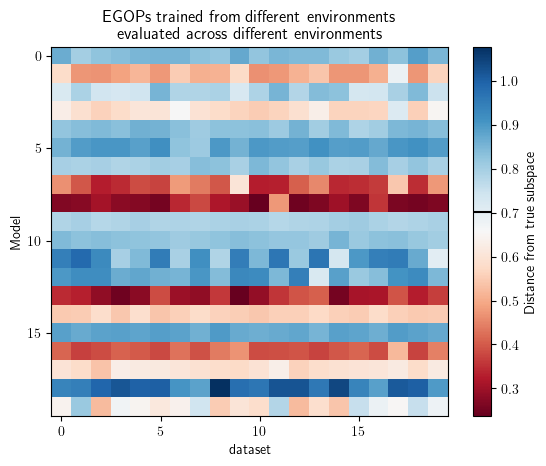

In [780]:
# This image shows that distance doesn't depend on env2 which means given a predictor it doesn't matter what dataset to use for finding
# the subspace. 
plt.imshow(cosine_dis, aspect='auto', cmap = plt.cm.RdBu)
cbar = plt.colorbar()
plt.xlabel('dataset')
plt.ylabel('Model')
plt.title('EGOPs trained from different environments \n evaluated across different environments');
plt.xticks(ticks = range(0, T, 5));
plt.yticks(ticks = range(0, T, 5));

cbar.set_label('Distance from true subspace')
cbar.ax.axhline( [cosine_dis.diagonal(0,0,1).mean()], c='k')

plt.savefig(image_dir + '/individual_performance.png')

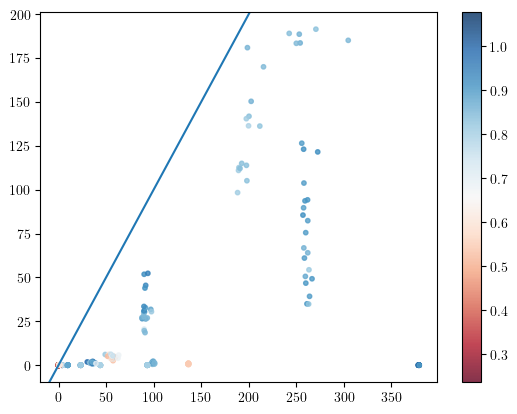

In [800]:
def ill_conditioning(mat):
    s = np.linalg.svd(mat, compute_uv = False)
    return s[:k]

singular_vals = list(map(lambda row: list(map(ill_conditioning , row)), matrix))
small_idx = cosine_dis.ravel() > 0.1

plt.scatter(*np.array(singular_vals).reshape((-1,2))[small_idx,:].T, c = cosine_dis.ravel()[small_idx], s = 10, cmap = plt.cm.RdBu, alpha = 0.8)
plt.axline((0,0),slope = 1)
plt.colorbar()
#plt.xlim((0,80));
#plt.ylim((0,80));

In [706]:
# angles from the help of other environments
compute_dist(M, B, colspace = True, aggregation_method=partial(mean_aggregation, normalization = True))

array([0.9541532, 0.5540304], dtype=float32)

In [707]:
U, S, Vh = np.linalg.svd(M, full_matrices = False)
top_r = 4
# important directions in column space of M. Each column corresponds to a single dataset applied to various models.
U_imp = U[:,:top_r].T.reshape((-1, D), order = 'C').T
U_imp_normalized = U_imp / np.sqrt((U_imp ** 2).sum(axis = 0, keepdims = True))

# important directions in row space of M. Each row corresponds to different dataset applied to the same predictor
V_imp = Vh[:top_r,:].reshape((-1, D), order = 'C').T
V_imp_normalized = V_imp / np.sqrt((V_imp ** 2).sum(axis = 0, keepdims = True))

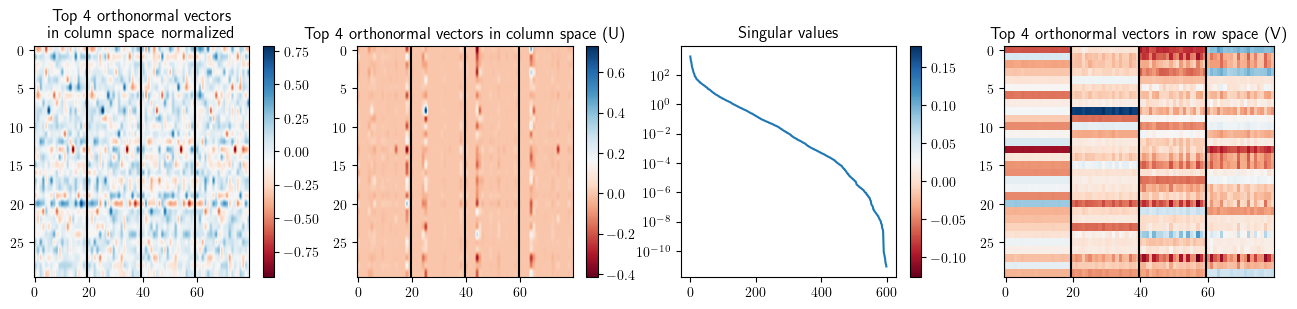

In [781]:
fig, axes = plt.subplots(1,4,figsize=(16,3))


im1 = axes[3].imshow(V_imp , aspect = 'auto', cmap = plt.cm.RdBu)
axes[3].set_title(f'Top {top_r} orthonormal vectors in row space (V)')
plt.colorbar(im1, ax = axes[2])

axes[2].plot(S)
axes[2].set_yscale('log')
axes[2].set_title('Singular values')

im2 = axes[1].imshow(U_imp , aspect = 'auto', cmap = plt.cm.RdBu)
axes[1].set_title(f'Top {top_r} orthonormal vectors in column space (U)')
plt.colorbar(im2, ax = axes[1])

im0 = axes[0].imshow(U_imp_normalized , aspect = 'auto', cmap = plt.cm.RdBu)
axes[0].set_title(f'Top {top_r} orthonormal vectors \n in column space normalized')
plt.colorbar(im0, ax = axes[0])

# horizontal lines
for ax_id, ax in enumerate(axes.ravel()):
    if ax_id == 2: continue
    for i in range(top_r):
        ax.axvline(i * T - 0.5 , c = 'k')

fig.savefig(image_dir + '/svd.png')

In [658]:
tensor = torch.stack( list(map(lambda matrow: torch.stack(matrow, dim = -1) , matrix)), axis = -1).detach().numpy().swapaxes(2,3) # [D, D, T,T']
#tensor_normalized = torch.stack( list(map(lambda matrow: torch.stack(matrow, dim = -1) , matrix_normalized)), axis = -1).detach().numpy().swapaxes(2,3) # [D, D, T,T']

# implements a decomposition of \| Ut @ M \|^2 = sum_{e'} \| sum_{e} Ut_e @ M_{e,e'}  \|^2
# Notice that Ut @ M should be proposional to Vt
slc = [0]
U_imp = U[:,slc].T.reshape((-1, D), order = 'C').T
slice_left_multiplication = np.einsum( 'ijbk,ib->jk' , tensor, U_imp) 
slice_left_multiplication_norm = (slice_left_multiplication ** 2).sum(axis = 0)
# check
print(slice_left_multiplication_norm.sum(), ((U[:,slc].T @ M.detach().numpy())**2).sum())

# implements a decomposition of \| M @ V \|^2 = sum_{e} \| sum_{e'} M_{e,e'} @ V_e' \|^2
# Notice that M @ V should be proportional to U
V_imp = Vh[slc,:].reshape((-1, D), order = 'C').T
slice_right_multiplication = np.einsum( 'ijkb,jb->ik' , tensor, V_imp) 
slice_right_multiplication_norm = (slice_right_multiplication ** 2).sum(axis = 0)
# check
print(slice_right_multiplication_norm.sum(), ((M.detach().numpy() @ Vh[slc,:].T )**2).sum())

12342389000.0 12342388000.0
12342385000.0 12342388000.0


In [660]:
slice_right_multiplication_norm.argsort(), cosine_dis.diagonal().argsort()

(array([15,  4,  3, 16,  9,  7, 11,  0,  6, 14, 19, 18, 17, 12, 13,  1,  2,
         5,  8, 10]),
 array([ 4,  3,  9, 15,  0,  5,  7, 16,  6, 14,  2, 19, 12, 18, 13, 17,  8,
         1, 11, 10]))

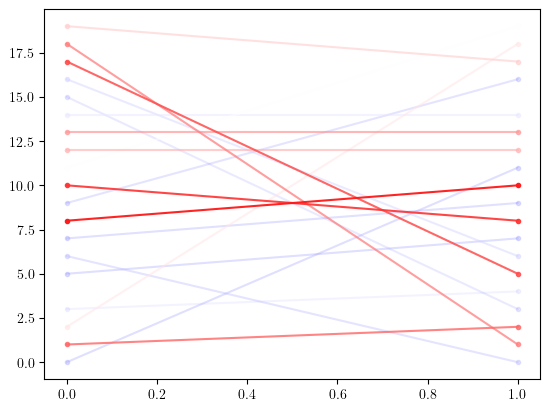

In [661]:
fig, ax = plt.subplots()

viridis = plt.colormaps.get_cmap('bwr')

for i, (left_val, right_val) in enumerate(zip(cosine_angles[:,:,0].diagonal().argsort(), slice_right_multiplication_norm.argsort())):
    ax.plot([0,1], [left_val, right_val], '.-', color = viridis(i / T), alpha = i / T)

## Large experiment

In [674]:
D = 30 # ambient dimension of the problem
n = 30 # number of samples per environment
sigma = 0.5 # variance 
k = 2
T = 20 # number of environments
sim_size = 10

In [675]:
def pipeline(
    D = 100, # ambient dimension of the problem
    n = 50, # number of samples per environment
    sigma = 1e-3, # variance 
    k = 2, # number of indices
    T = 20 # number of environments
):

    # generate data
    B, data_train, data_test, nonlinearities = generate_data_from_multiple_envs(D, n, sigma, k ,T) 

    # compute optimal predictors
    predictors, optimal_parameters, errors = run(data_train, data_test)

    # compute the egop matrix for each environment evaluated across other environmnets
    M, matrix = compute_matrix(predictors, data_train, data_test)
    
    # Per environment distance
    dist = lambda egop: compute_dist(egop, B, colspace = False)
    cosine_angles = np.array(list(map(dist, [matrix[env1][env2] for env1 in range(T) for env2 in range(T)]))).reshape((T,T,k), order = 'C') # [T,T,k]
    cosine_dis = np.sqrt( (cosine_angles ** 2).sum(-1) )

    # naive method
    tensor = torch.stack( list(map(lambda matrow: torch.stack(matrow, dim = -1) , matrix)), axis = -1).detach().numpy().swapaxes(2,3) # [D, D, T,T']
    naive_angles = dist( tensor.mean(axis = (2,3)) )
    naive_dis = np.sqrt( (naive_angles ** 2).sum(-1) )
    
    my_method_dis = defaultdict(list)
    for colspace, normalization in product([False, True], [False, True]):
        my_cosine_angles = compute_dist(M, B, colspace = colspace, aggregation_method=partial(mean_aggregation, normalization = normalization))
        my_cosine_dis = np.sqrt( (my_cosine_angles ** 2).sum(-1) )
        
        my_method_dis['colspace'].append( colspace ) 
        my_method_dis['normalization'].append( normalization )
        my_method_dis['angles'].append( my_cosine_dis )

    my_method_dis['angles'] = np.array(my_method_dis['angles']) 
    
    return my_method_dis, cosine_dis, naive_dis

def run_simulations(
    sim_size = 5, # number of simulations
    D = 100, # ambient dimension of the problem
    n = 80, # number of samples per environment
    sigma = 1e-3, # variance 
    k = 2, 
    T = 20 # number of environments
):
    cosine_distances = []
    my_method = []
    naive_method = []
    
    for simulation_id in range(sim_size):
        print(f'simulation {simulation_id} is running')
        my_method_dis, cosine_dis, naive_dis = pipeline(D,n, sigma, k, T)
    
        cosine_distances.append(cosine_dis)
        my_method.append(my_method_dis)
        naive_method.append( naive_dis )

    # concatenate the results
    cosine_distances_ = np.stack(cosine_distances, axis = -1).transpose((2,0,1)) # [sim_size,T,T]
    naive_distances_ = np.array(naive_method) # [sim_size,]
    # flatten the dictionary
    names = list(my_method[0].keys())
    values = list(zip(*map(lambda x: list(x.values()), my_method)))
    my_method_dict = {key: np.array(val) for key, val in zip(names, values)}
    # my_method_dict['angles'] will have shape [sim_size, #param_configs]
    
    return my_method_dict, cosine_distances_, naive_distances_

In [676]:
my_perf = []
avg_perf = []
naive_perf = []

for n in tqdm(range(20, 401, 20)):
    print(n, '\n\n')
    
    my_method_perf, avg_method_perf, naive_method_perform = run_simulations(sim_size, D, n, sigma, k , T)
    
    df = pd.DataFrame({key: val.ravel() for key, val in my_method_perf.items()})
    df.reset_index(names = 'sim ID', inplace=True)
    df['n'] = n
    
    my_perf.append(df)

    df_avg = pd.DataFrame( avg_method_perf.reshape((-1,sim_size)), index = pd.MultiIndex.from_product( [ range(T), range(T) ], names = ['Model ID', 'Dataset ID'] ) )
    df_avg = pd.melt(df_avg, var_name = 'sim ID', value_name = 'angles')
    df_avg['n'] = n

    avg_perf.append(df_avg)

    df_naive = pd.DataFrame( naive_method_perform, columns=['angles'])
    df_naive.reset_index(names = 'sim ID', inplace = True)
    df_naive['n'] = n

    naive_perf.append(df_naive)

    

  0%|                                                        | 0/20 [00:00<?, ?it/s]

20 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


  5%|██▍                                             | 1/20 [00:49<15:38, 49.37s/it]

40 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 10%|████▊                                           | 2/20 [02:19<21:58, 73.24s/it]

60 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 15%|███████▏                                        | 3/20 [04:14<26:12, 92.48s/it]

80 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 20%|█████████▍                                     | 4/20 [06:36<29:49, 111.87s/it]

100 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 25%|███████████▊                                   | 5/20 [09:28<33:22, 133.48s/it]

120 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 30%|██████████████                                 | 6/20 [12:58<37:13, 159.55s/it]

140 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 35%|████████████████▍                              | 7/20 [17:10<41:09, 190.00s/it]

160 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 40%|██████████████████▊                            | 8/20 [22:18<45:27, 227.28s/it]

180 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 45%|█████████████████████▏                         | 9/20 [28:20<49:24, 269.53s/it]

200 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 50%|███████████████████████                       | 10/20 [35:45<53:57, 323.77s/it]

220 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 55%|█████████████████████████▎                    | 11/20 [44:33<57:57, 386.34s/it]

240 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 60%|██████████████████████████▍                 | 12/20 [55:10<1:01:38, 462.34s/it]

260 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 65%|███████████████████████████▎              | 13/20 [1:07:53<1:04:33, 553.41s/it]

280 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 70%|█████████████████████████████▍            | 14/20 [1:22:55<1:05:52, 658.81s/it]

300 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 75%|███████████████████████████████▌          | 15/20 [1:40:19<1:04:35, 775.00s/it]

320 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 80%|█████████████████████████████████▌        | 16/20 [2:00:58<1:00:58, 914.59s/it]

340 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 85%|████████████████████████████████████▌      | 17/20 [2:24:52<53:32, 1070.81s/it]

360 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 90%|██████████████████████████████████████▋    | 18/20 [2:53:11<41:59, 1259.69s/it]

380 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


 95%|████████████████████████████████████████▊  | 19/20 [3:25:25<24:22, 1462.02s/it]

400 


simulation 0 is running
simulation 1 is running
simulation 2 is running
simulation 3 is running
simulation 4 is running
simulation 5 is running
simulation 6 is running
simulation 7 is running
simulation 8 is running
simulation 9 is running


100%|████████████████████████████████████████████| 20/20 [4:01:46<00:00, 725.32s/it]


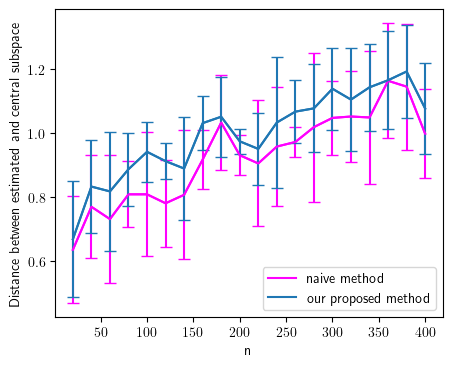

In [792]:
fig, ax = plt.subplots(figsize = (5,4))

# mn = pd.concat(avg_perf).groupby('n')['angles'].agg(['mean', 'std'])
# mn['mean'].plot(ax = ax, label='average performance across environments', color = 'k')
# ax.errorbar( mn.index.values, mn['mean'].values, yerr = mn['std'].values, color = 'k', capsize=4)

naive_mn = pd.concat(naive_perf).groupby('n')['angles'].agg(['mean', 'std'])
naive_mn['mean'].plot(ax = ax, label='naive method', color = 'magenta')
ax.errorbar( naive_mn.index.values, naive_mn['mean'].values, yerr = naive_mn['std'].values, color = 'magenta', capsize=4)

my_mn = (
    pd.concat(my_perf)
    .groupby(['colspace', 'normalization','n'])['angles']
    .agg(['mean', 'std'])
    .reset_index()
    .set_index('n')
)
for group_id, group in my_mn.groupby(['colspace', 'normalization']):
    if not group_id == (True, True):
        continue
    #group['mean'].plot(ax = ax, label = f'colspace = {group_id[0]}, normalization = {group_id[1]}')
    group['mean'].plot(ax = ax, label = 'our proposed method')
    col = ax.lines[-1].get_color()
    ax.errorbar( group.index.values, group['mean'].values, yerr = group['std'].values, color = col, capsize=4)
    
ax.legend(loc='lower right')
ax.set_ylabel('Distance between estimated and central subspace');

fig.savefig(image_dir + '/final_res.png')